<a href="https://colab.research.google.com/github/BSniegowski/ML-uni_course/blob/main/lab/08_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title imports
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title Demo
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

In [24]:
#@title MyModel
class MyModel(torch.nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, kernel_size=5, stride=3, padding=2),
        torch.nn.BatchNorm2d(32),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=1),
    )
    self.adaptivepool = torch.nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(32*6*6, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(512, 10),
    )
    
  def forward(self, x):
    x = self.conv(x)
    x = self.adaptivepool(x)
    x = torch.flatten(x, start_dim=1)
    x = self.classifier(x)
    return x

In [25]:
#@title show results
def show_results(logs):
  f, ax = plt.subplots(1, 2, figsize=(16, 5))
  ax[0].plot(logs['train_accuracy'], color='C%s' % i, linestyle='--', label='train')
  ax[0].plot(logs['test_accuracy'], color='C%s' % i, label='test')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(logs['train_loss'], color='C%s' % i, linestyle='--', label='train')
  ax[1].plot(logs['test_loss'], color='C%s' % i, label='test')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

In [ ]:
#@title DataLoaders
train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([ToTensor()]))

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=Compose([ToTensor()]))


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Device:  cuda:0


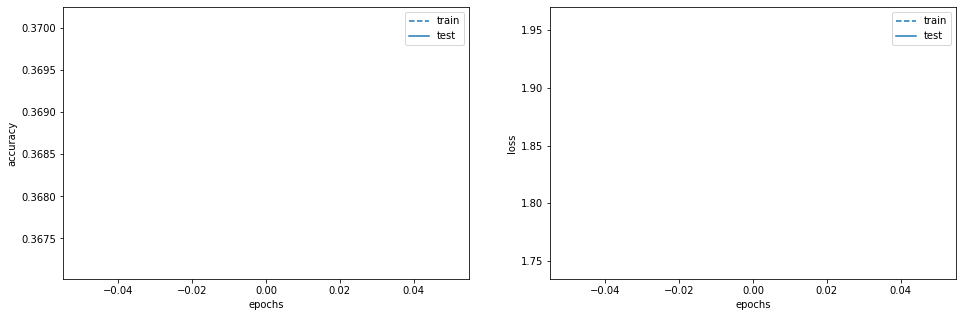

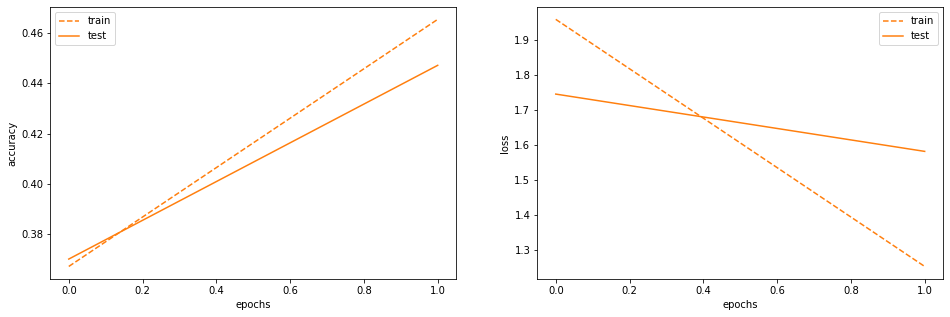

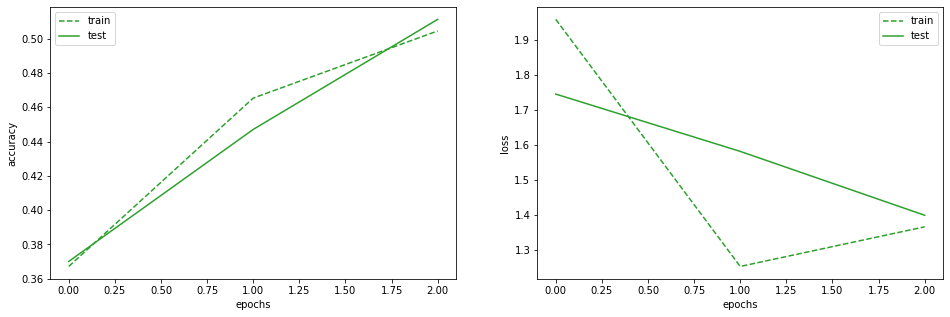

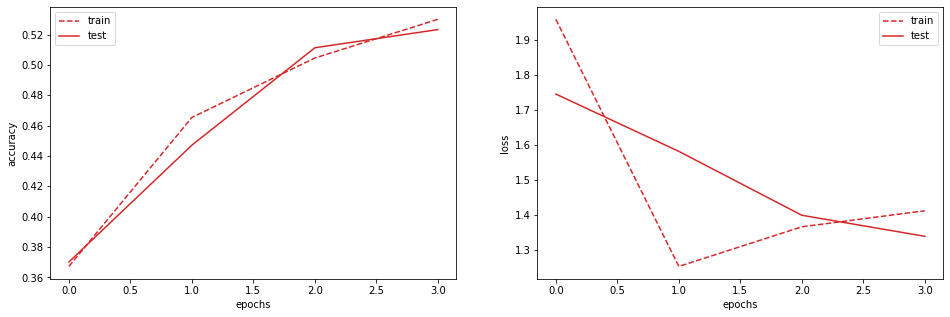

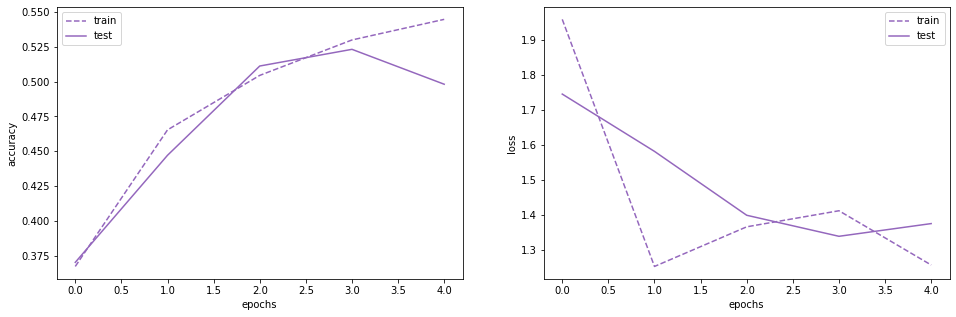

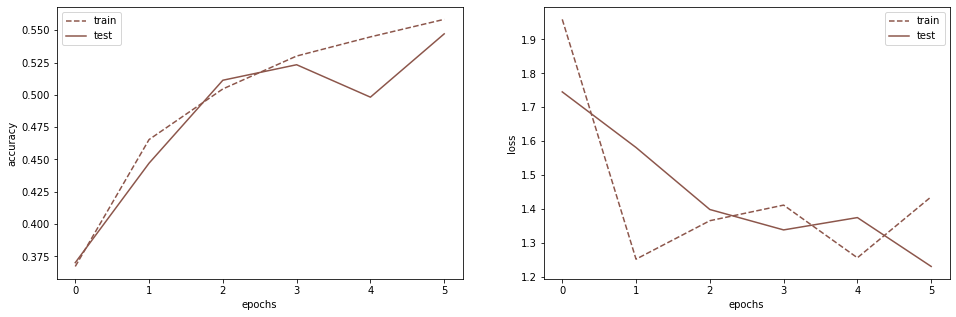

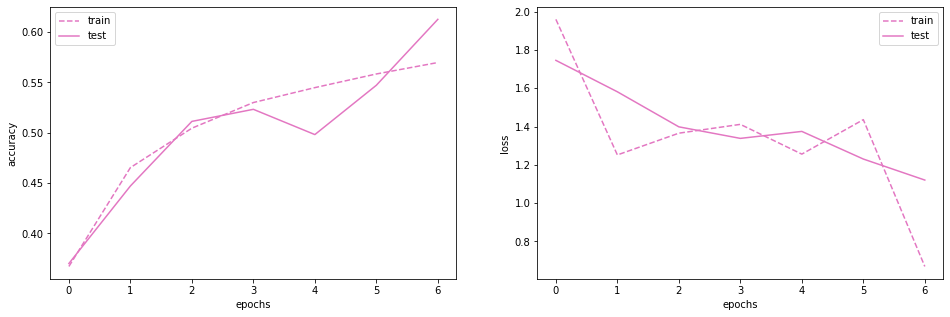

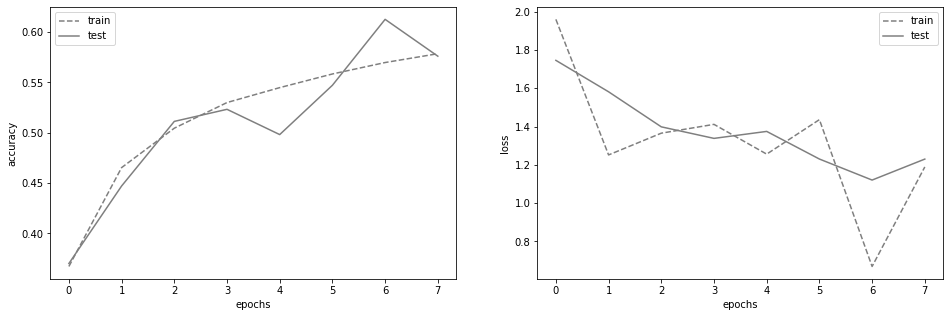

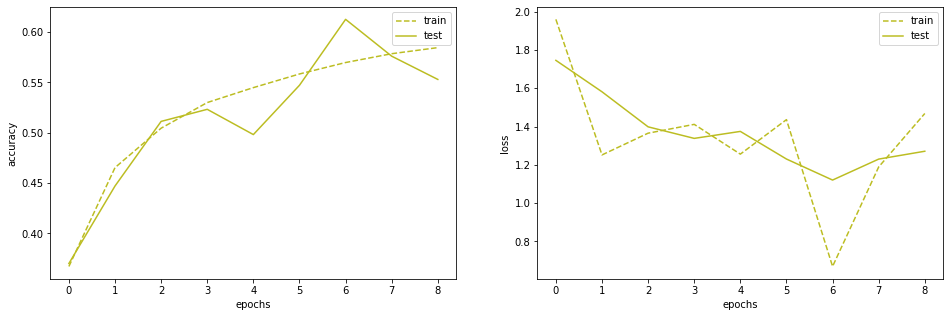

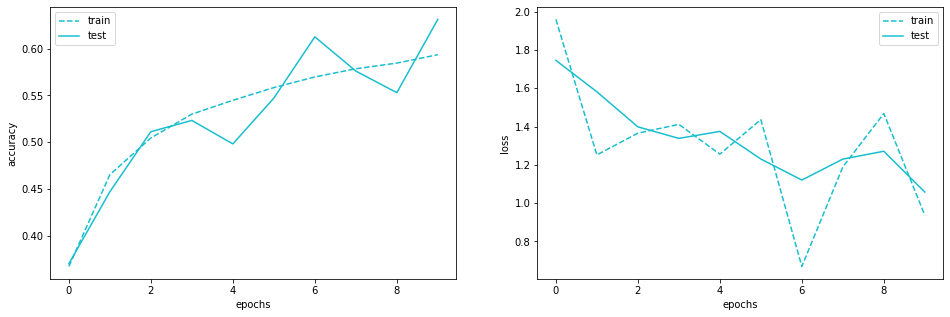

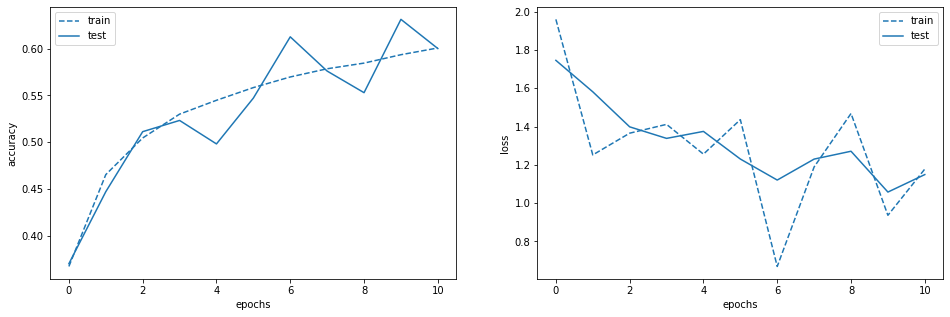

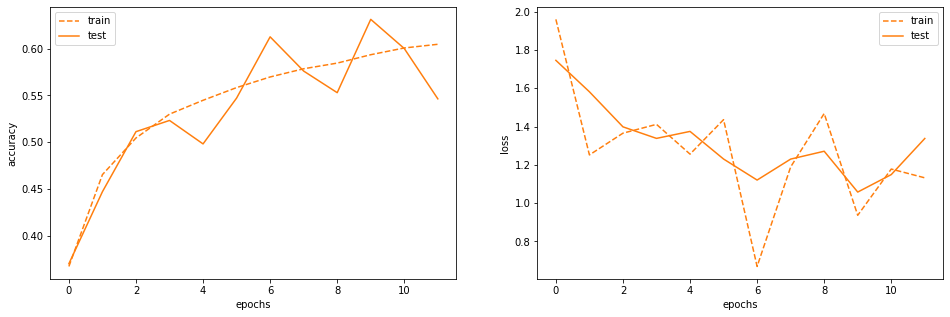

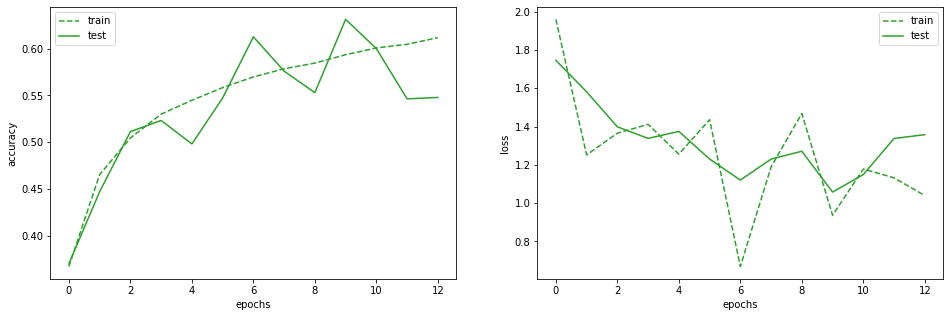

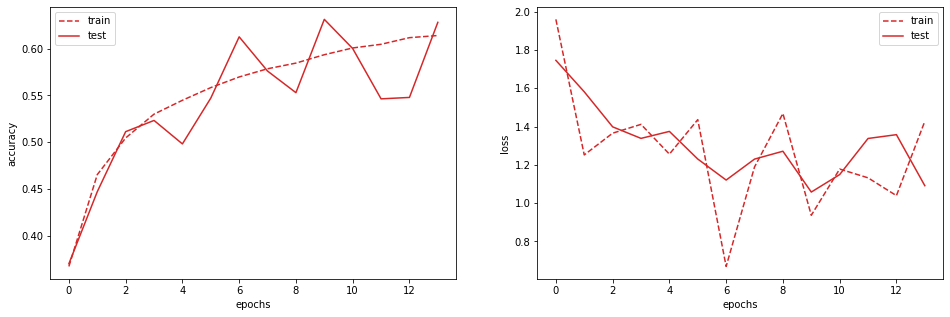

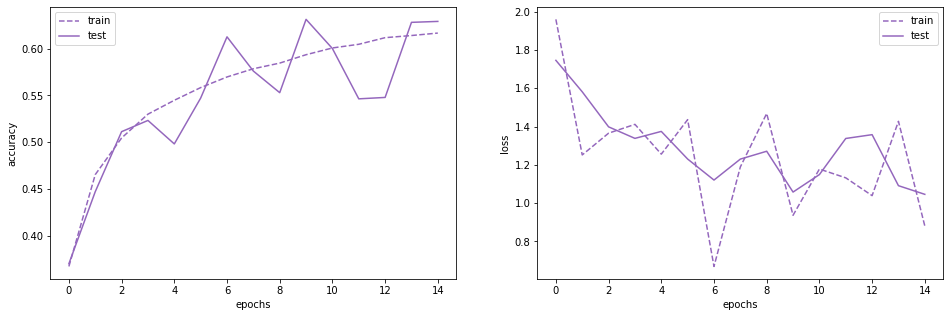

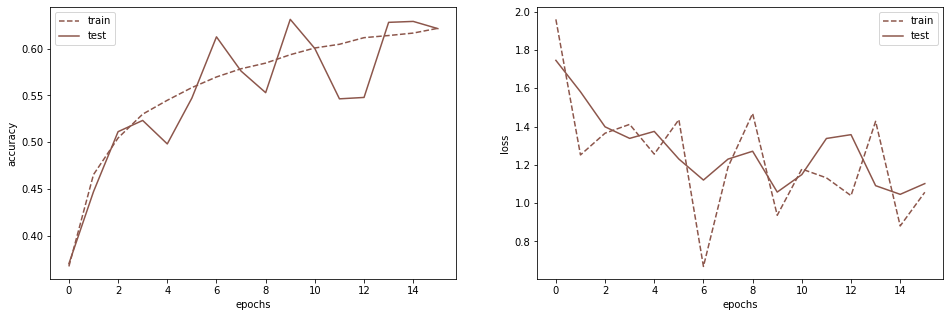

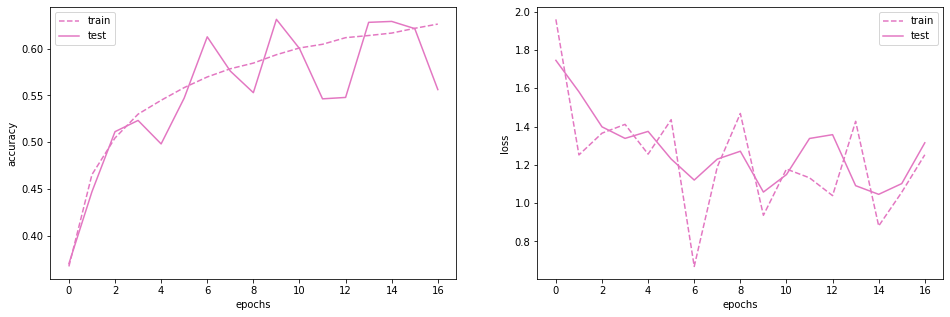

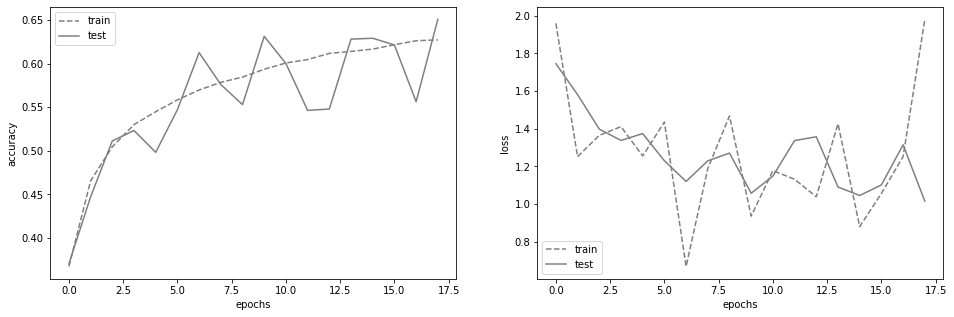

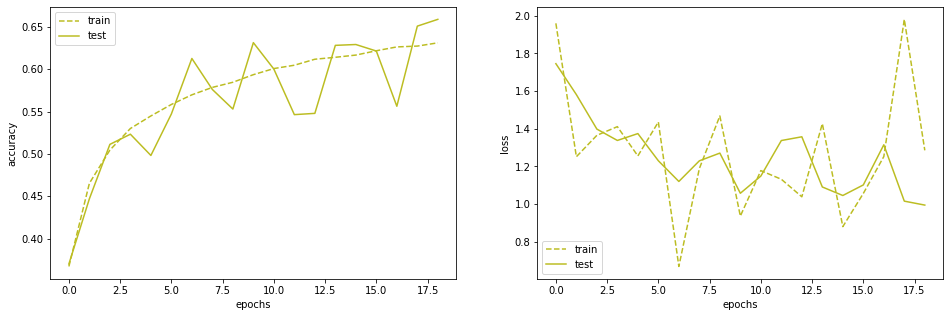

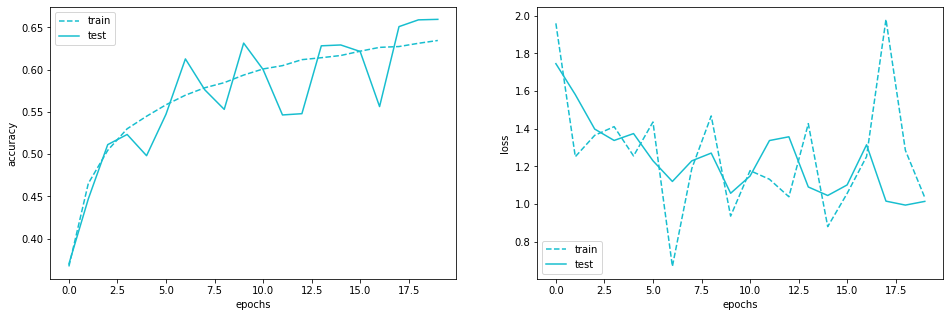

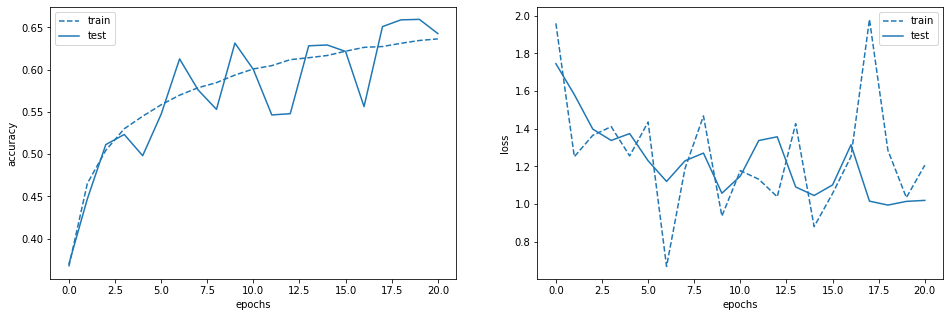

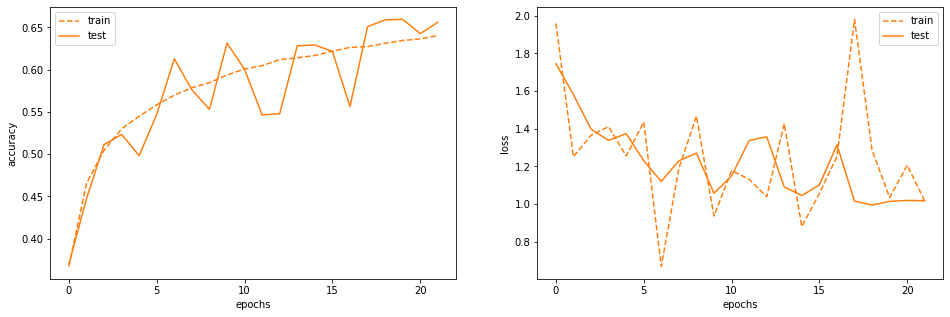

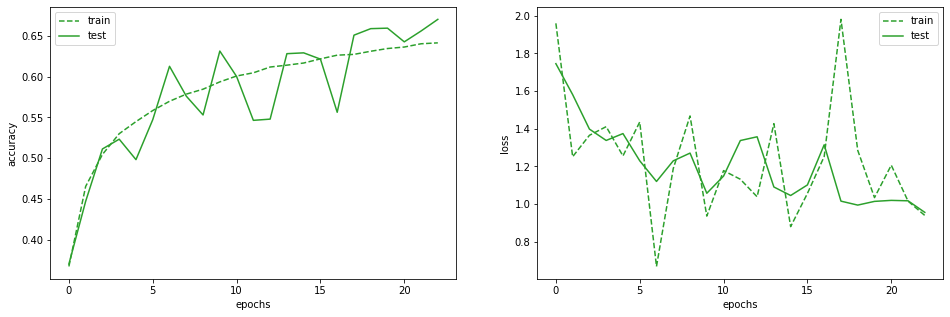

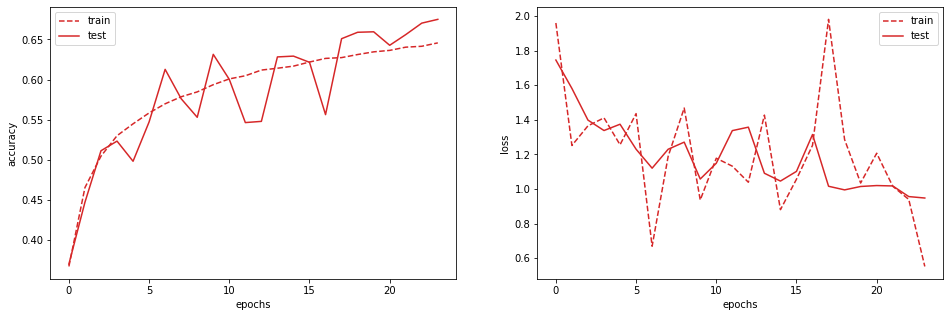

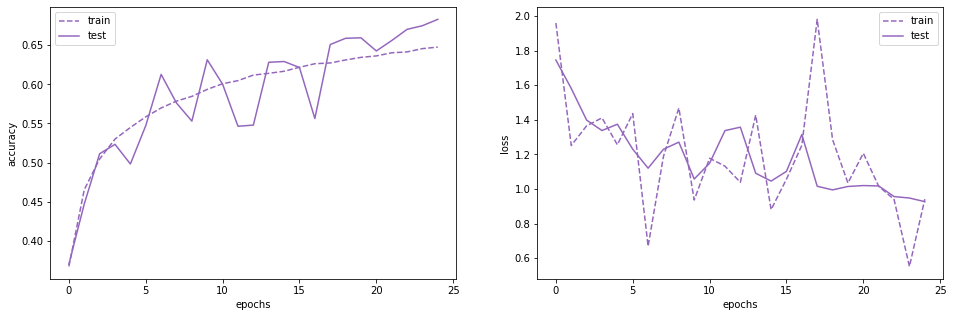

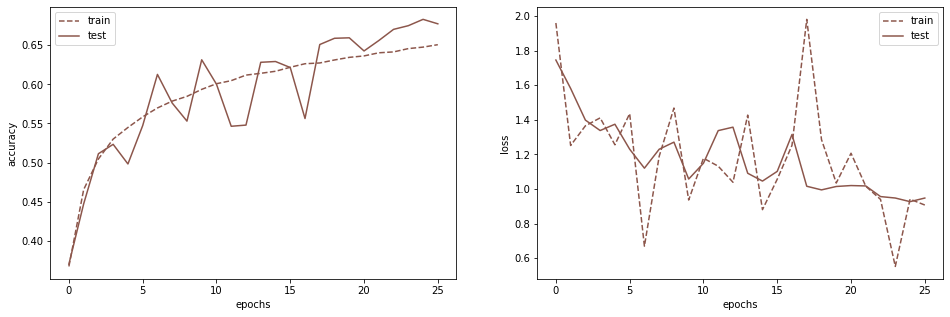

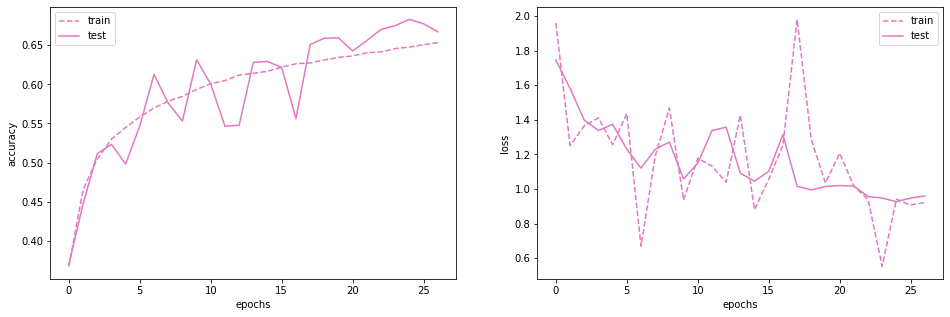

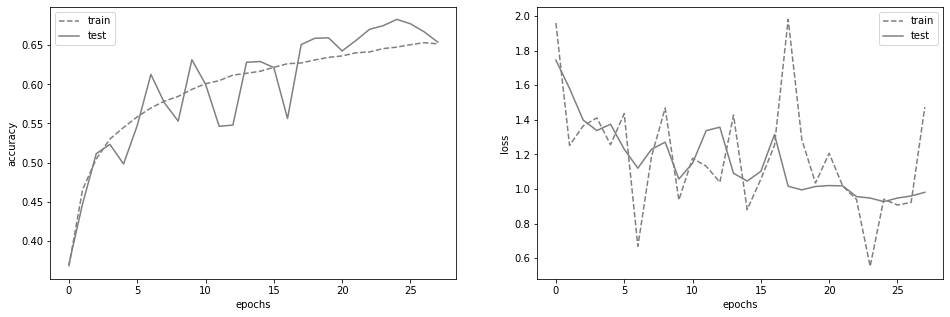

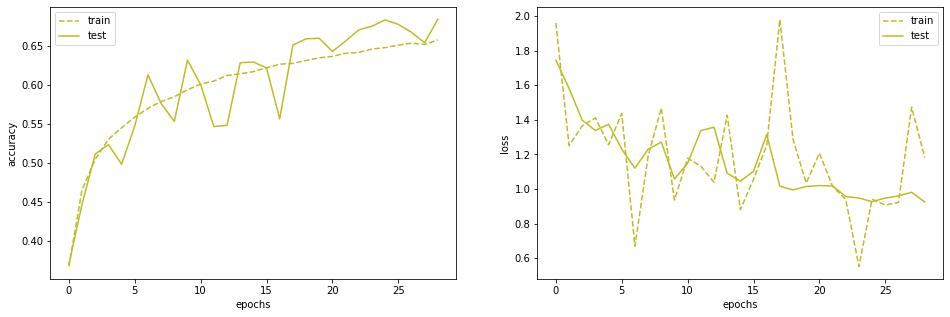

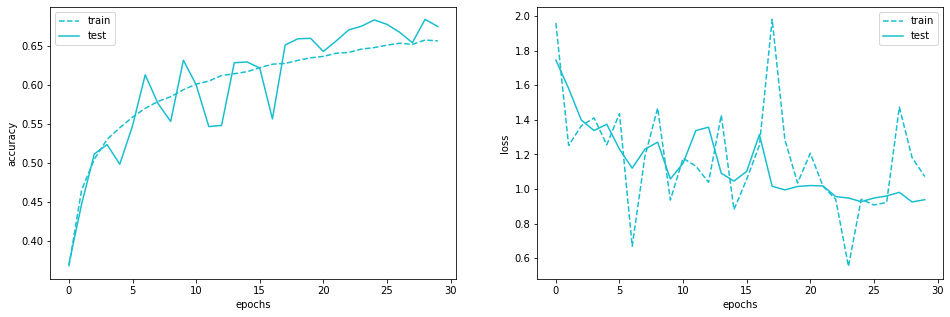

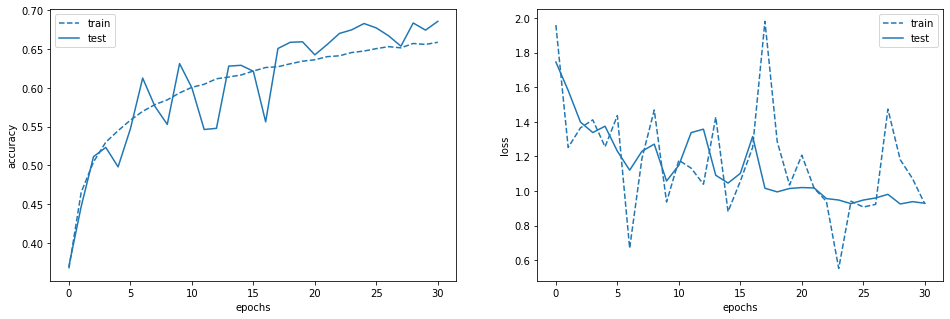

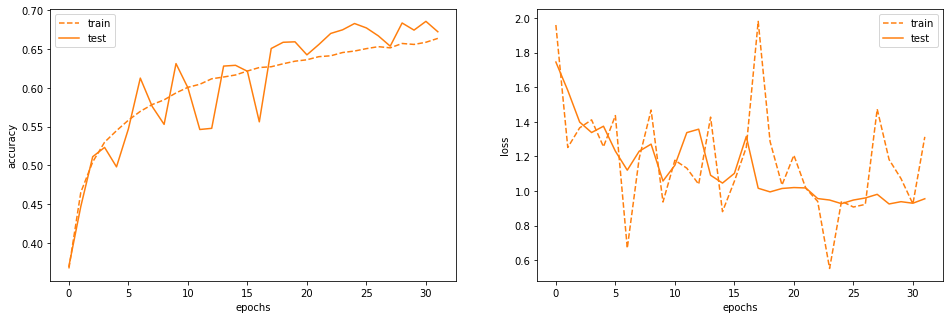

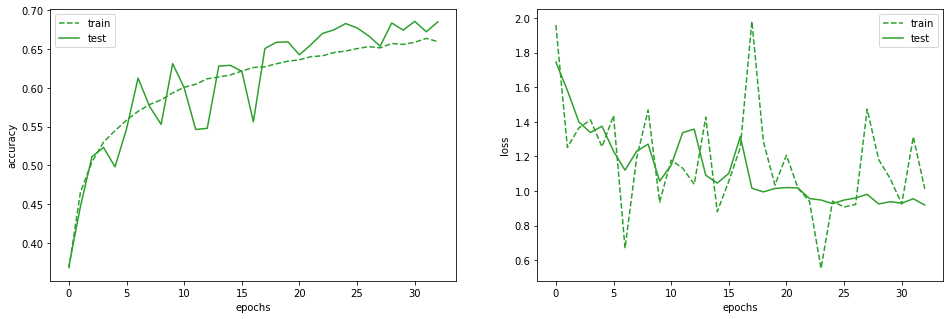

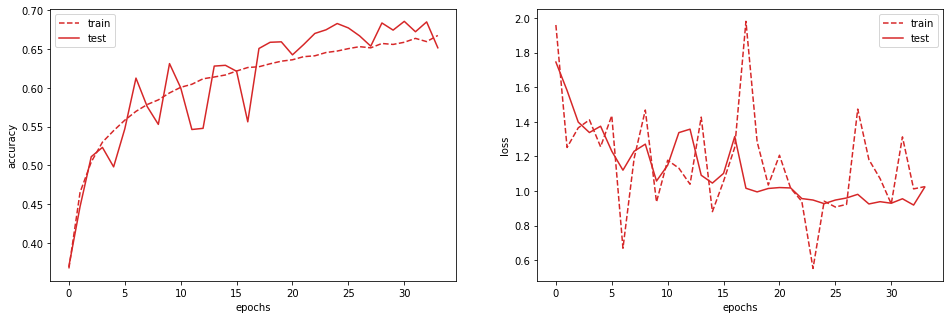

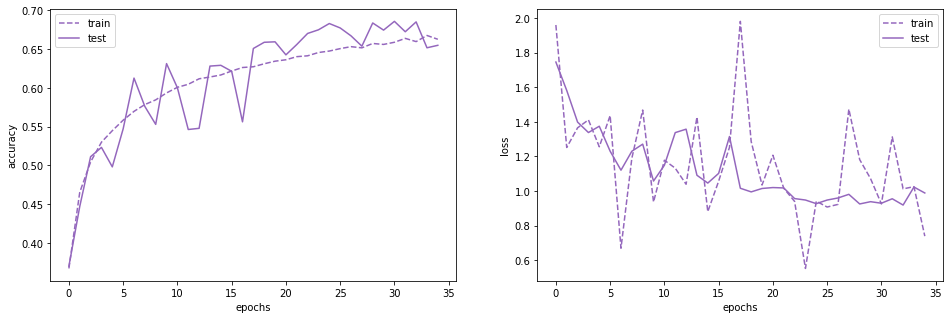

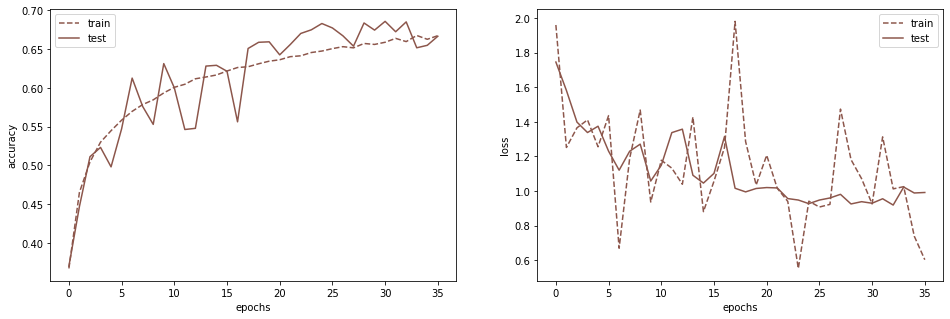

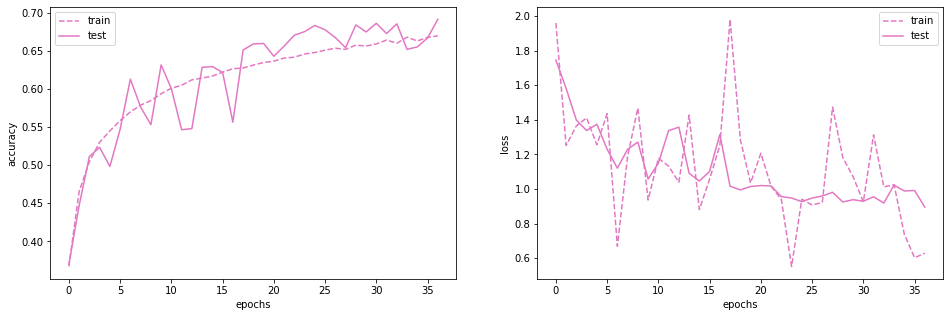

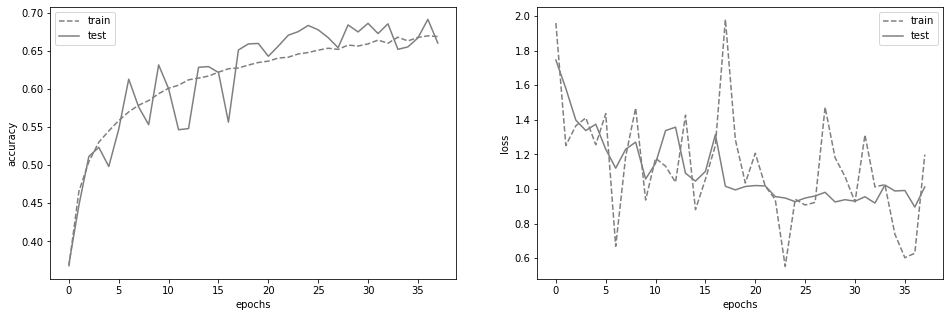

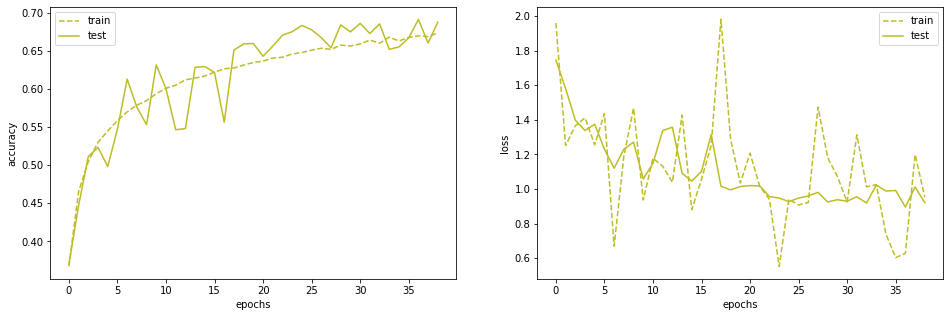

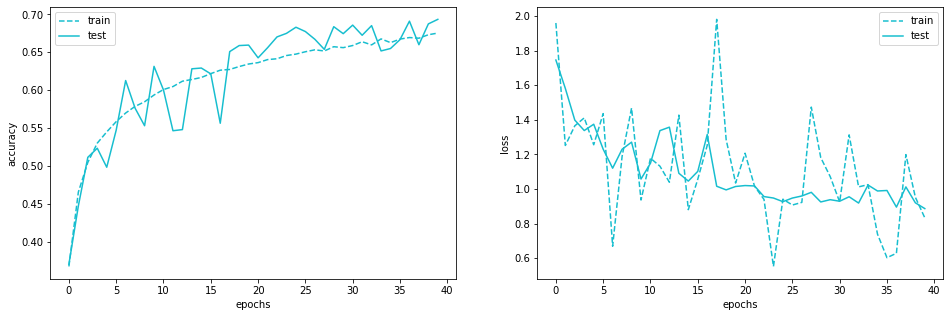

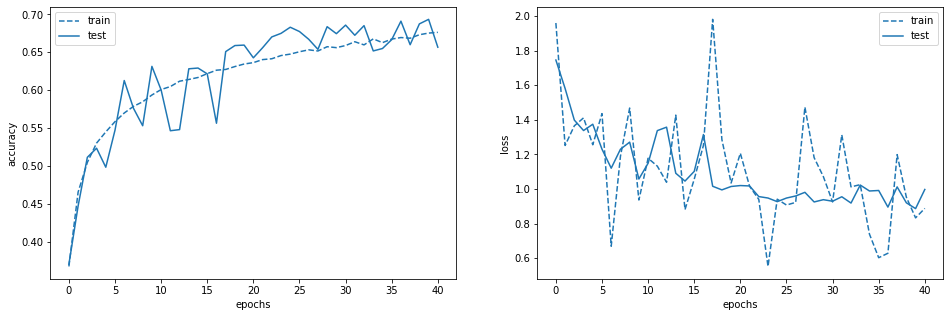

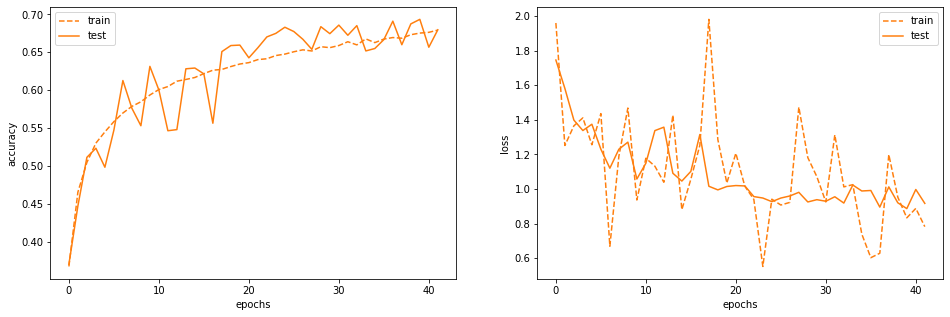

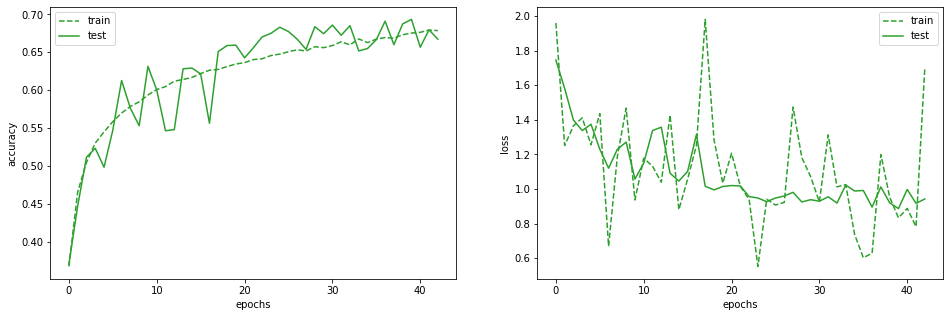

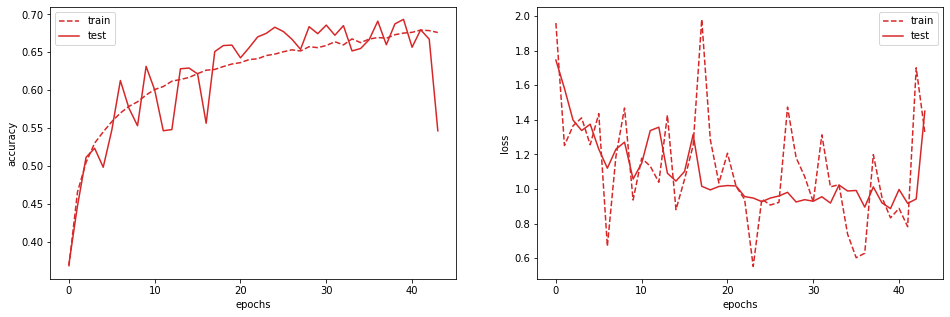

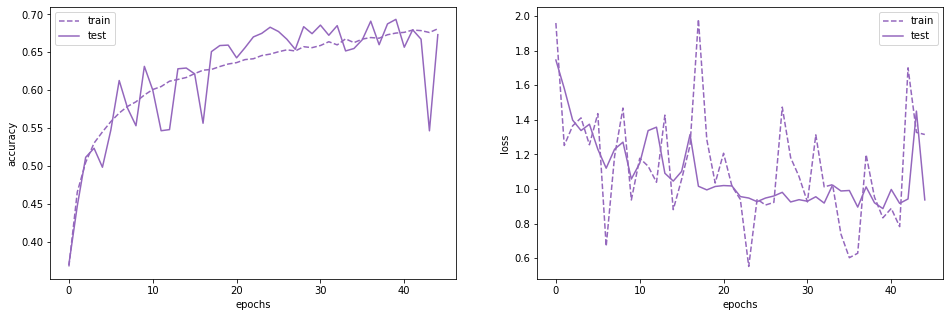

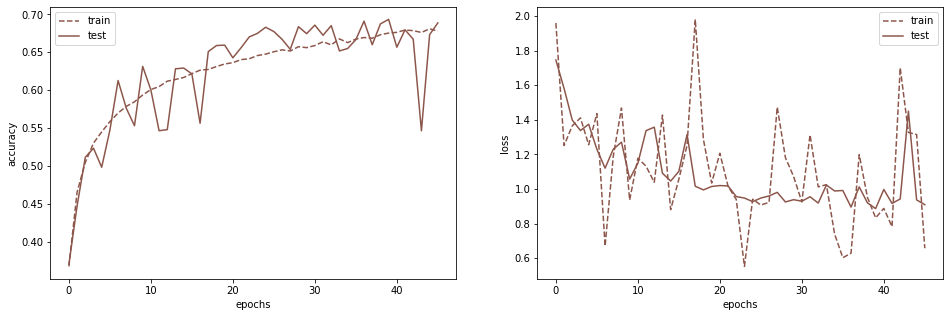

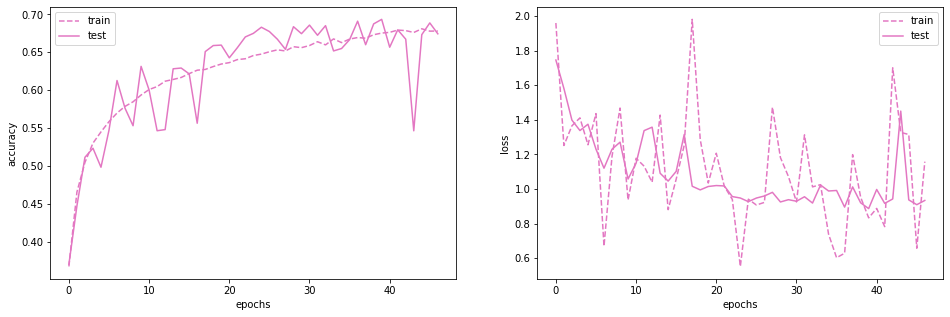

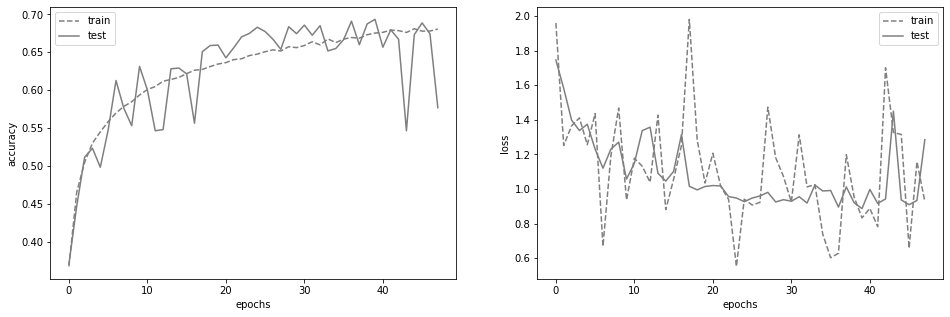

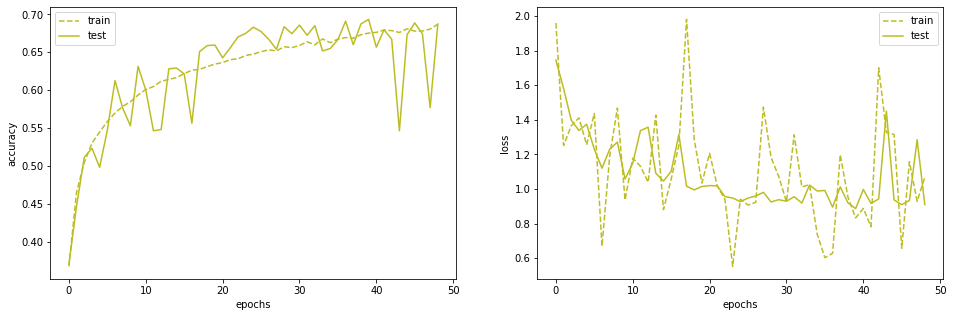

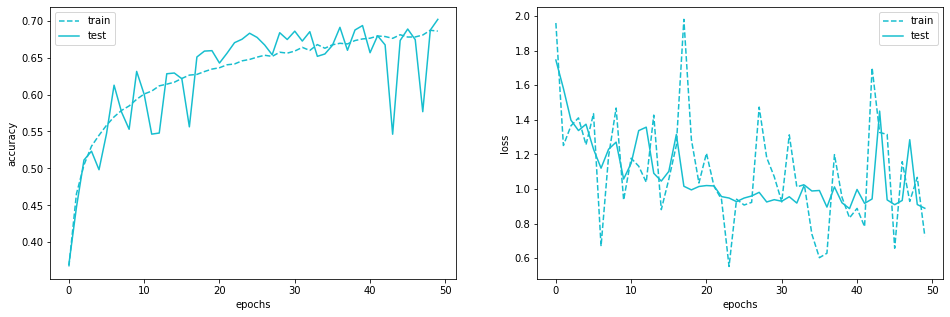

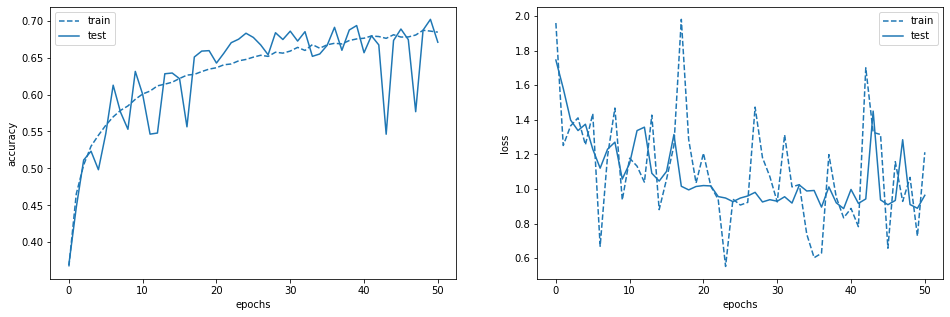

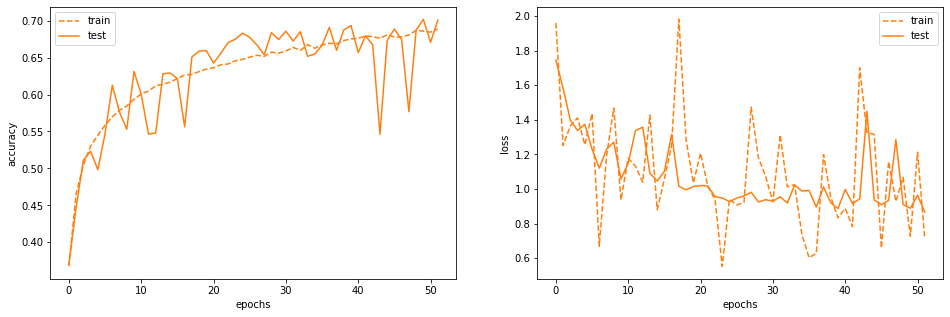

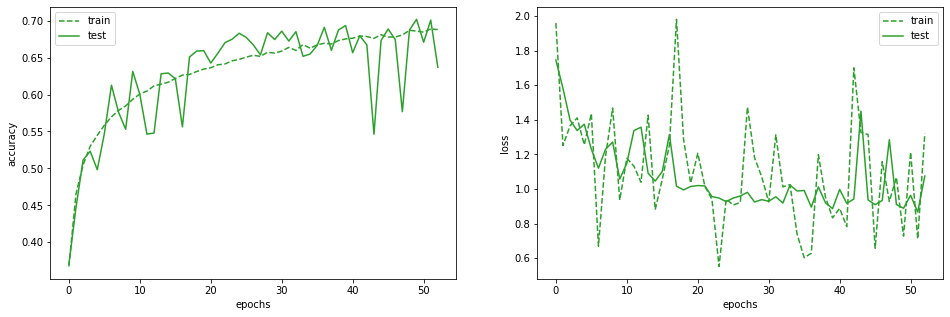

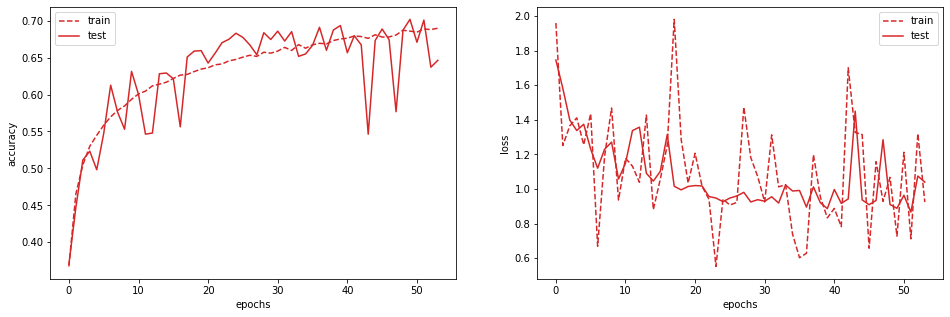

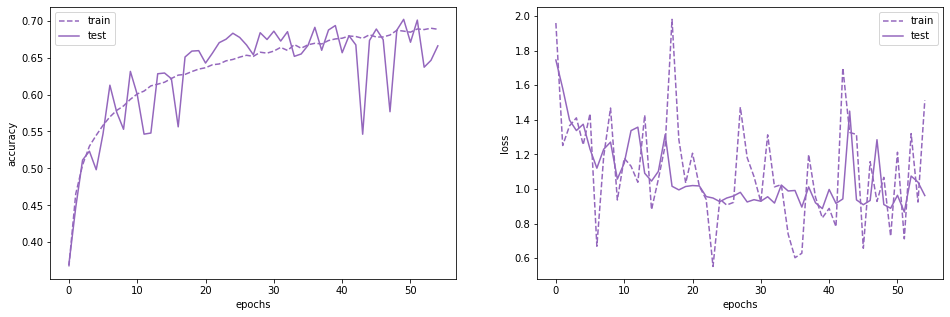

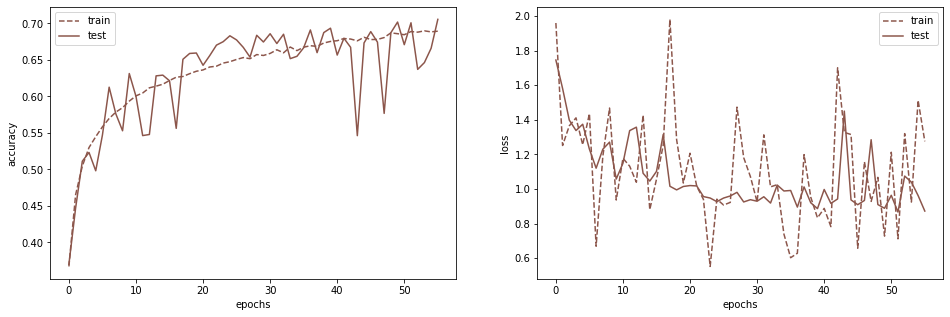

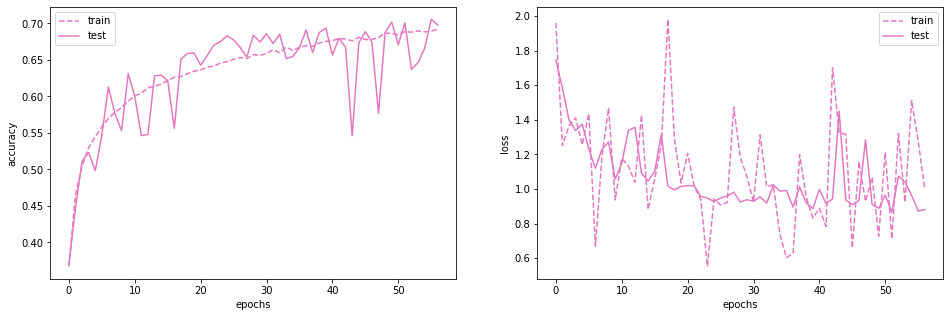

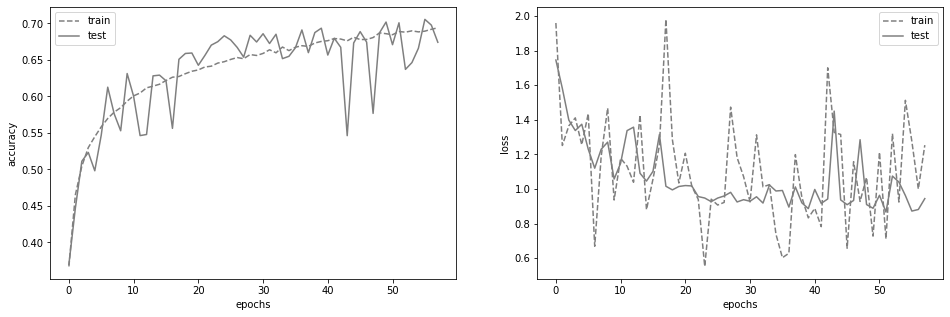

KeyboardInterrupt: ignored

In [5]:
#@title Training loop
model = MyModel()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)
model.to(device)

# Hiperparameters
learning_rate = 0.05
momentum = 0.1
n_epochs = 500

loss_fn = torch.nn.functional.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# for it in model.parameters():
#   print(it.size())

# for x, y in train_loader:
#   print(x.size())
#   output = layer(x)
#   print((output.reshape(output.shape[0],-1)).size())
#   break

logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
correct, numel = 0, 0

# for i in range(5):
#   print(i)
#   logs['test_accuracy'].append(torch.randint(low=0,high=10,size=(1,)))
#   logs['train_accuracy'].append(torch.randint(low=0,high=10,size=(1,)))
#   logs['test_loss'].append(torch.randint(low=0,high=10,size=(1,)))
#   logs['train_loss'].append(torch.randint(low=0,high=10,size=(1,)))
#   show_results(logs)
#   plt.pause(1e-10)
#   time.sleep(1)

# Training loop
for i in range(n_epochs):
  # print('test acc', logs['test_accuracy'])
  model.train()
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    output = model(x)
    y_pred = torch.argmax(output, dim=1)
    correct += torch.sum(y_pred == y).item()
    numel += train_loader.batch_size
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()

  logs['train_loss'].append(loss.item())
  logs['train_accuracy'].append(correct / numel)
  correct, numel = 0, 0

  model.eval()
  with torch.no_grad():
    for x_test, y_test in test_loader:
      x_test = x_test.to(device)
      y_test = y_test.to(device)
      output = model(x_test)
      y_pred = torch.argmax(output, dim=1)
      correct += torch.sum(y_pred == y_test).item()
      numel += test_loader.batch_size
    loss = loss_fn(output, y_test)

  logs['test_loss'].append(loss.item())
  logs['test_accuracy'].append(correct / numel)
  correct, numel = 0, 0
  show_results(logs)
  plt.pause(1e-10)

In [22]:
#@title DataLoaders with augmentations
from torchvision.transforms import RandomHorizontalFlip, RandomRotation
train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([
                            RandomHorizontalFlip(),
                            RandomRotation(10),
                            ToTensor()
                            ])
                        )

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=Compose([ToTensor()]))


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Device:  cuda:0


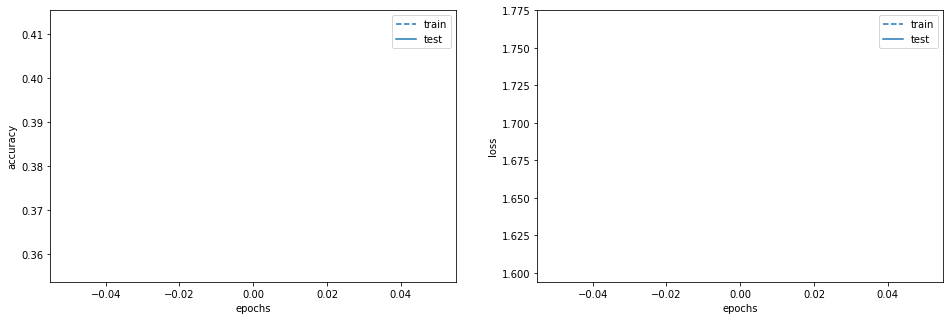

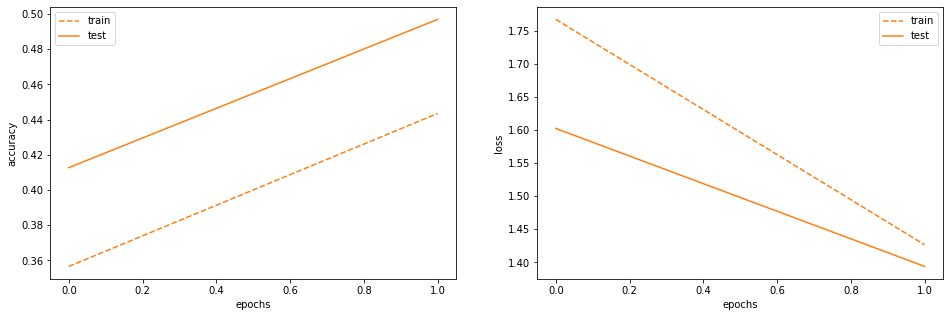

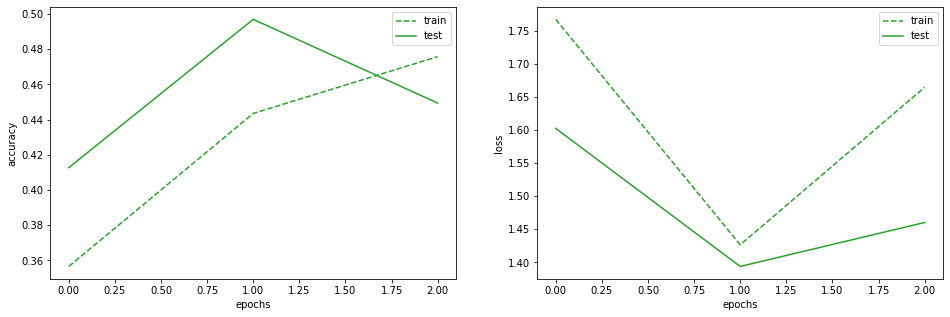

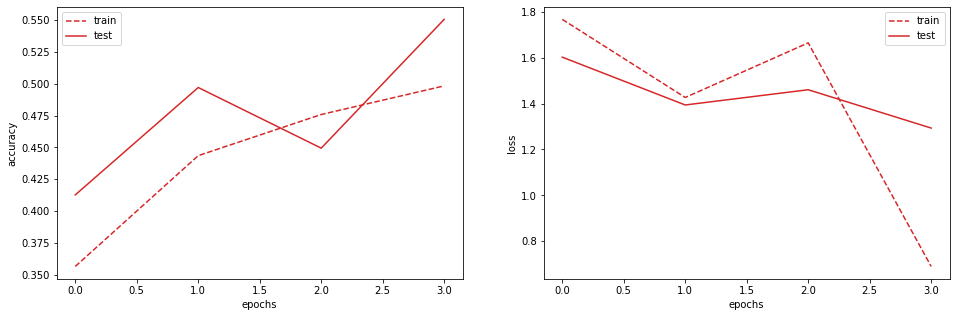

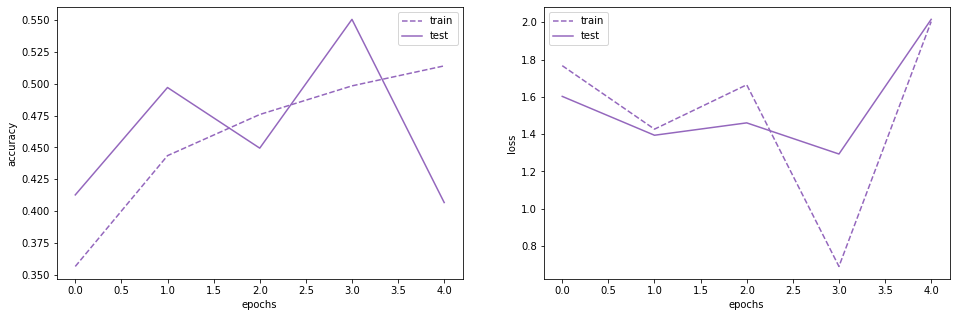

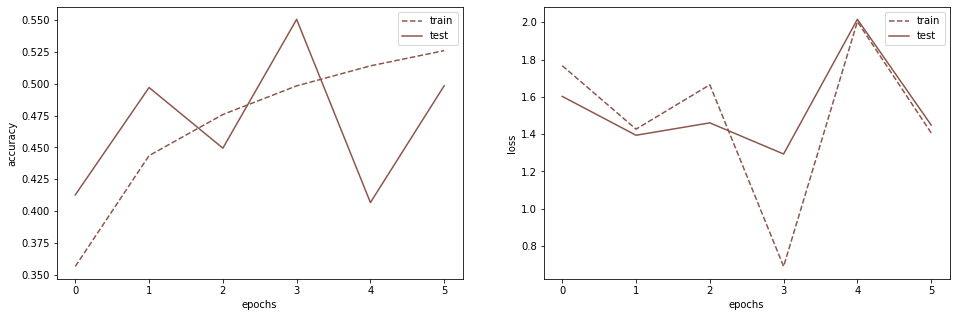

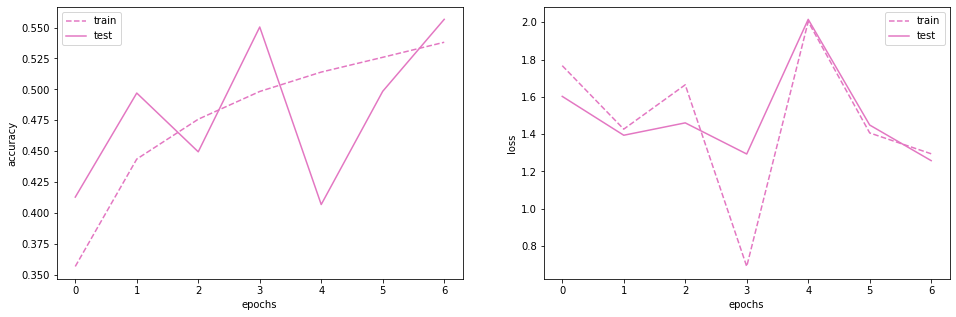

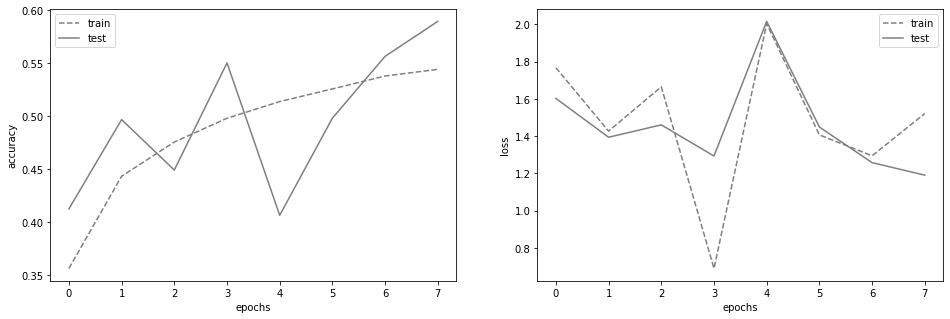

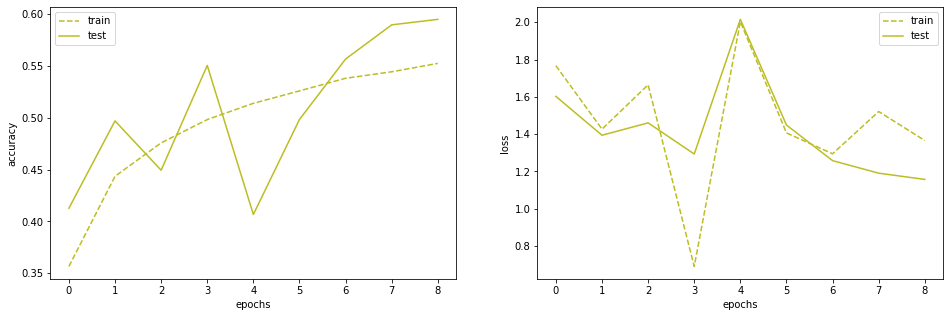

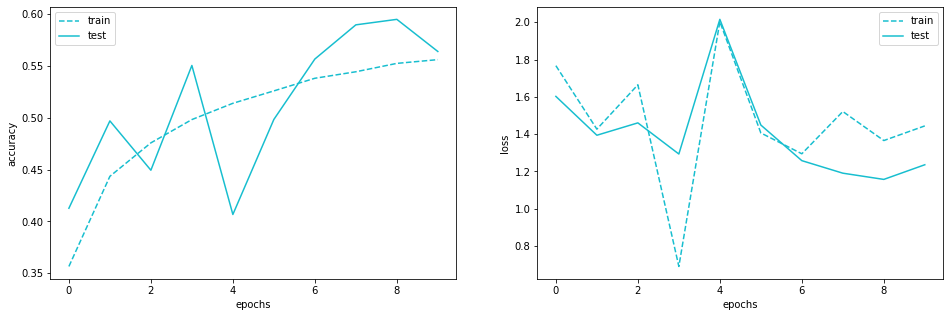

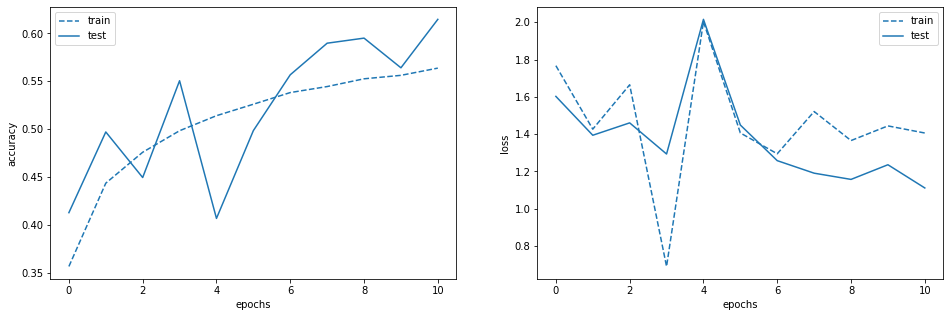

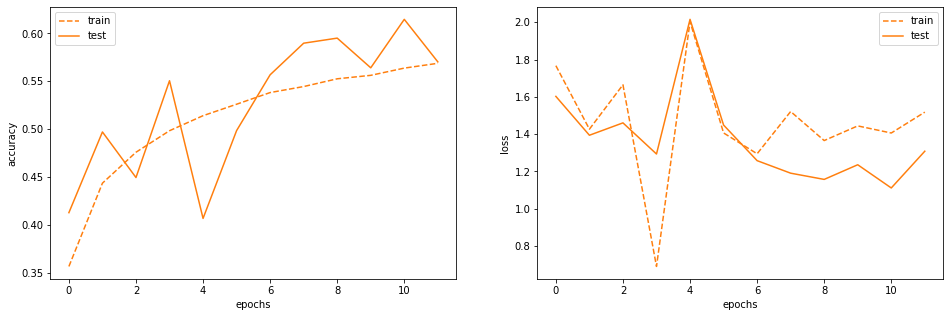

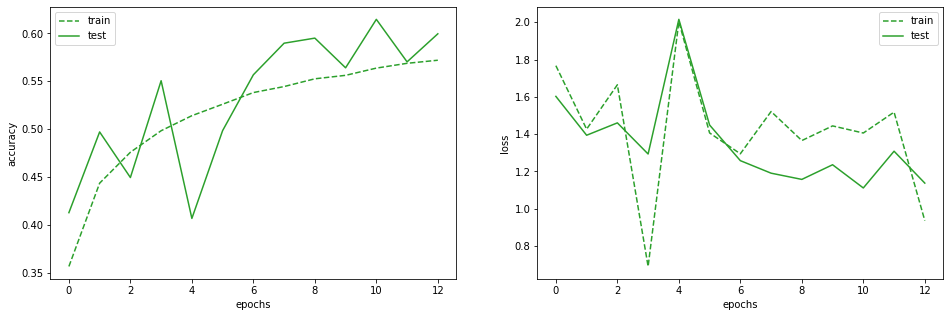

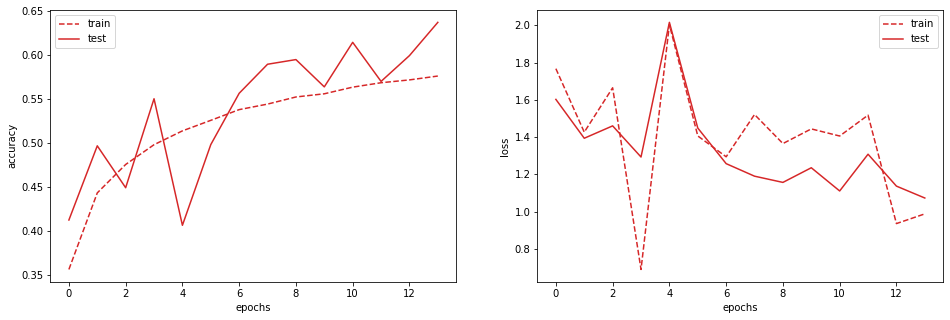

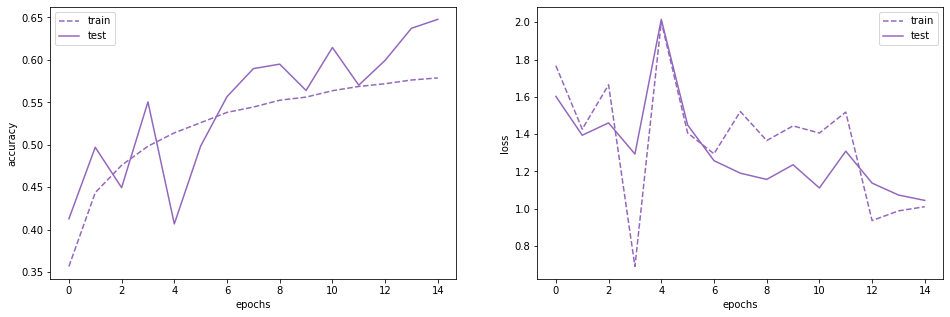

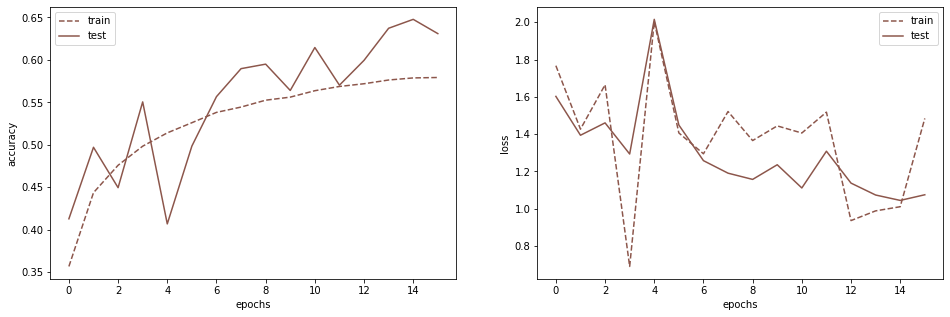

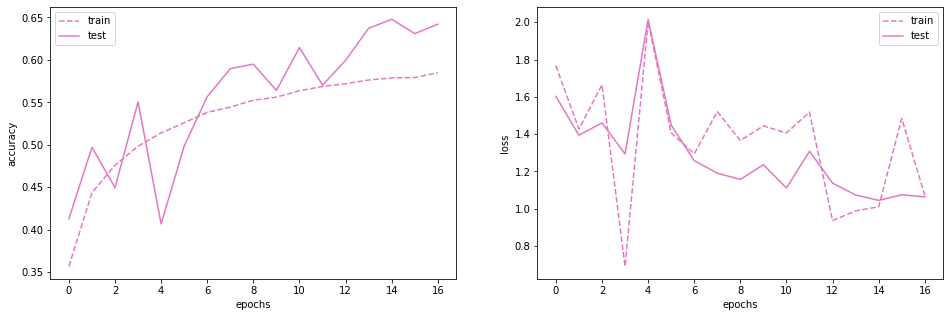

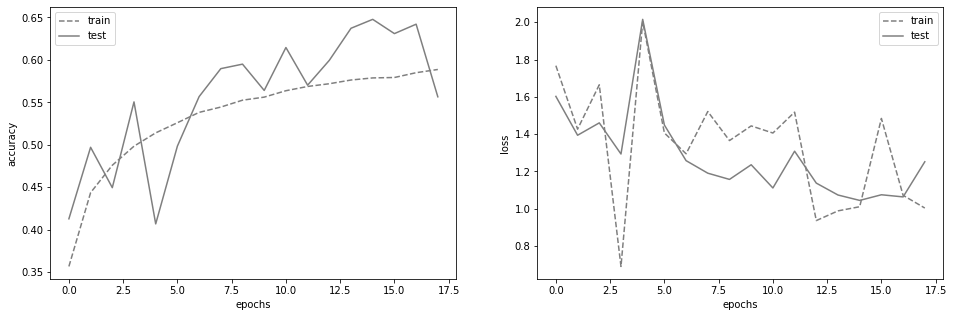

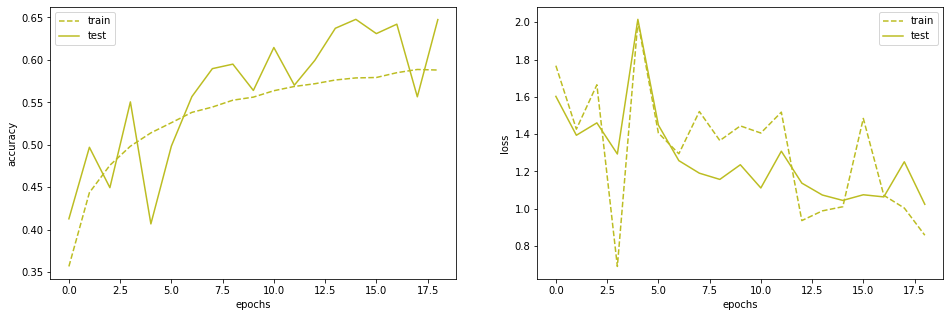

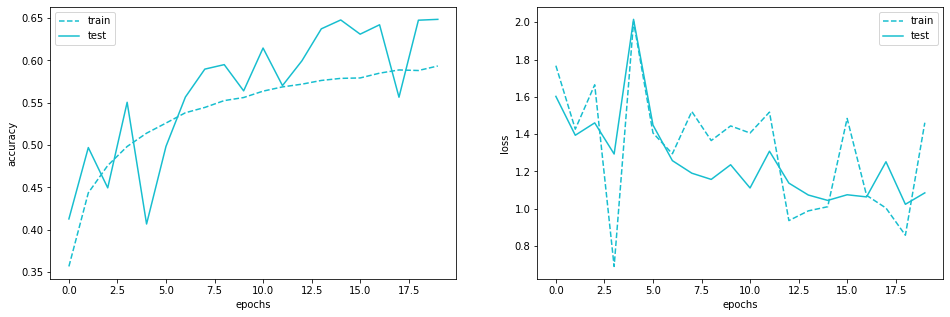

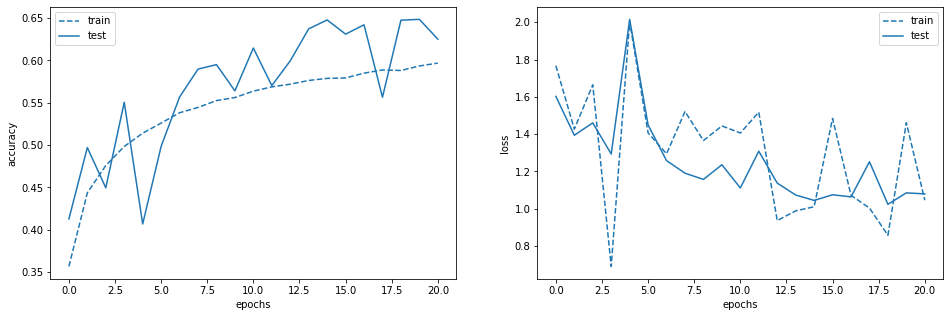

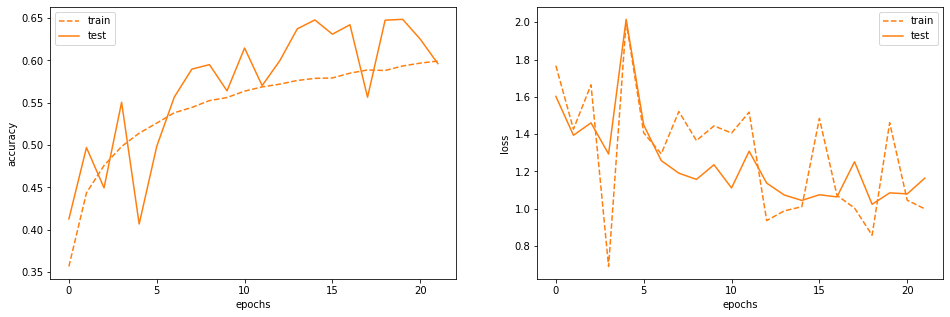

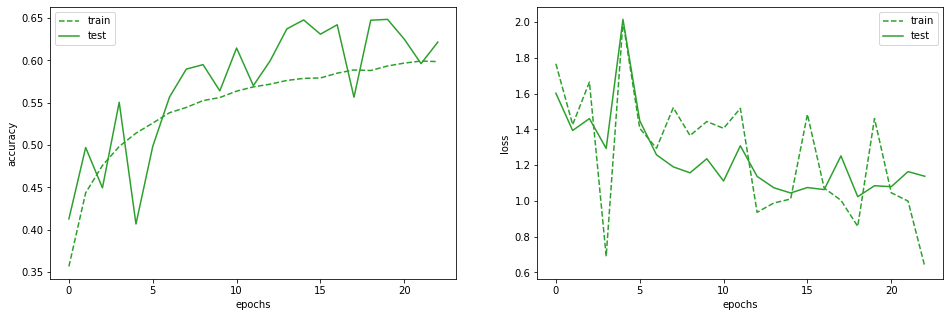

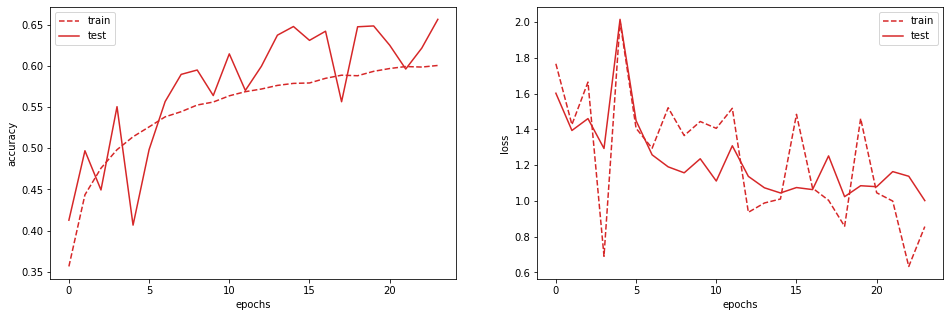

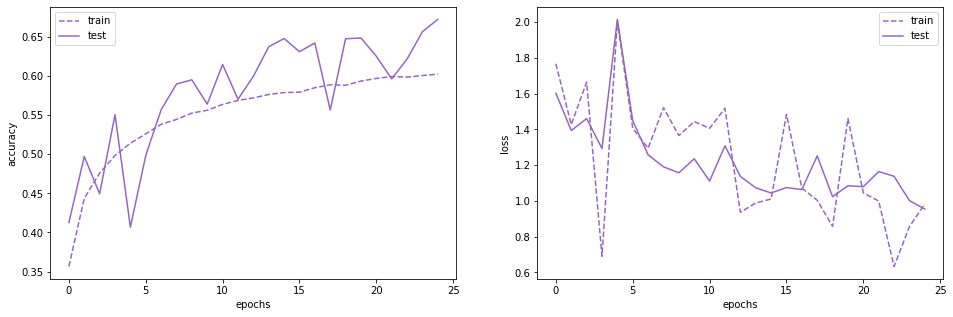

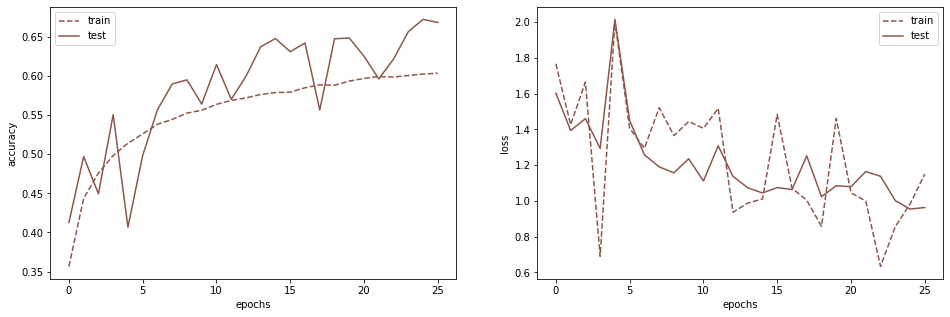

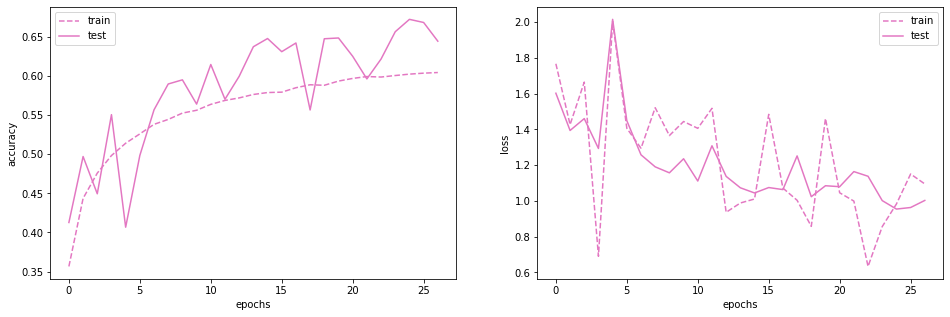

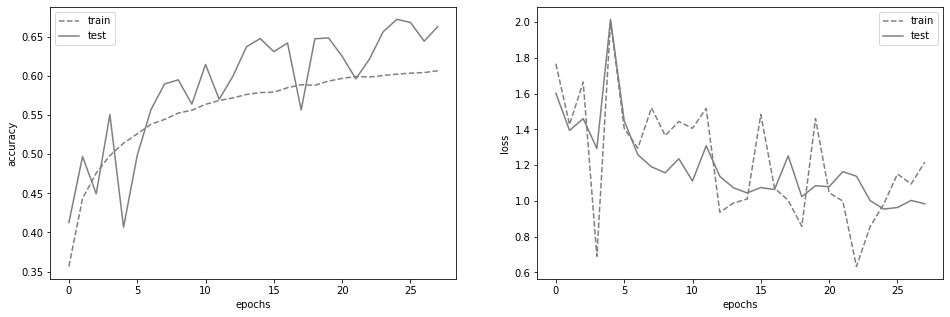

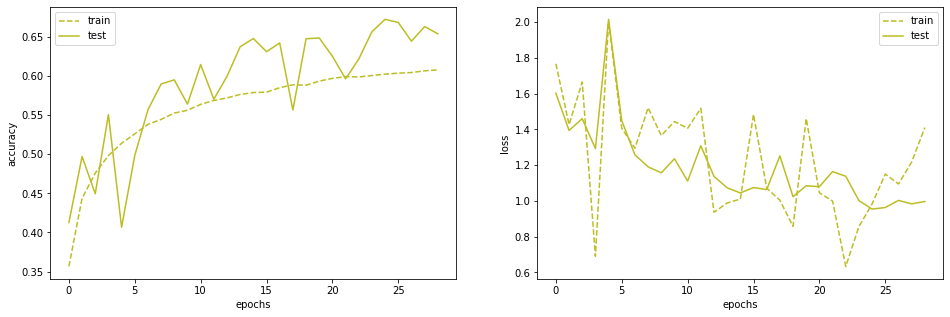

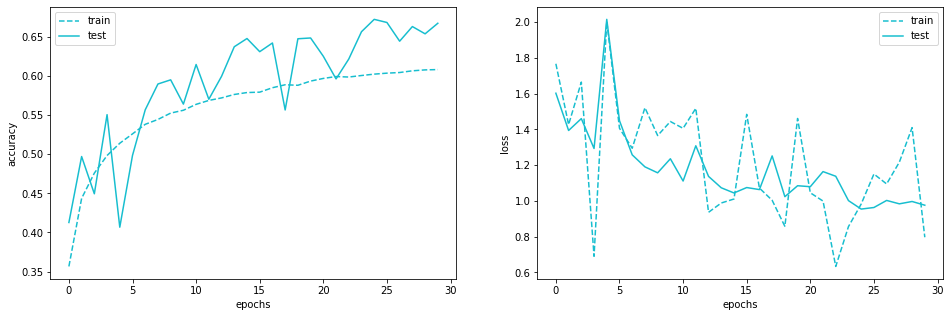

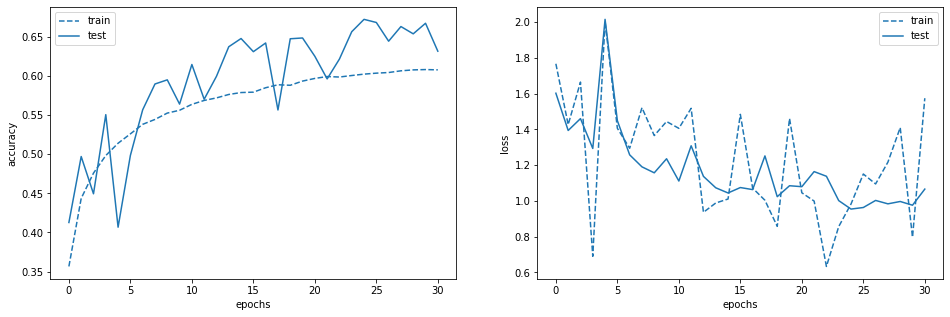

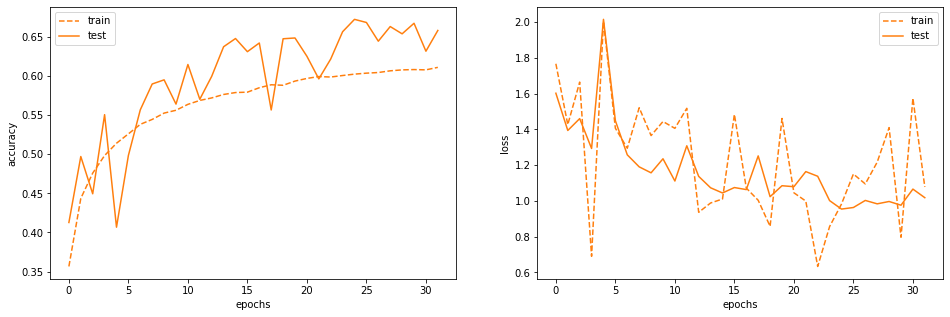

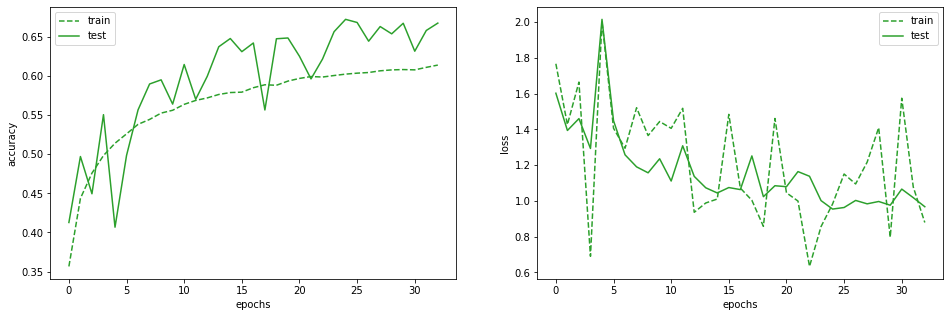

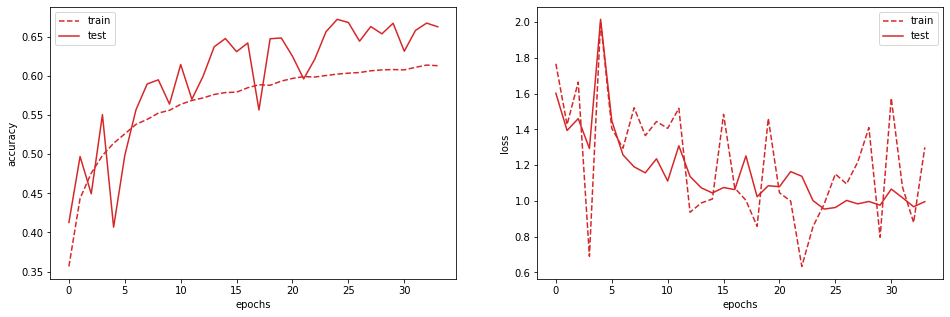

KeyboardInterrupt: ignored

In [26]:
#@title Training loop after augmentation
model = MyModel()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)
model.to(device)

# Hiperparameters
learning_rate = 0.05
momentum = 0.1
n_epochs = 500

loss_fn = torch.nn.functional.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

logs = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}
correct, numel = 0, 0


# Training loop
for i in range(n_epochs):
  # print('test acc', logs['test_accuracy'])
  model.train()
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    output = model(x)
    y_pred = torch.argmax(output, dim=1)
    correct += torch.sum(y_pred == y).item()
    numel += train_loader.batch_size
    loss = loss_fn(output, y)
    loss.backward()
    optimizer.step()

  logs['train_loss'].append(loss.item())
  logs['train_accuracy'].append(correct / numel)
  correct, numel = 0, 0

  model.eval()
  with torch.no_grad():
    for x_test, y_test in test_loader:
      x_test = x_test.to(device)
      y_test = y_test.to(device)
      output = model(x_test)
      y_pred = torch.argmax(output, dim=1)
      correct += torch.sum(y_pred == y_test).item()
      numel += test_loader.batch_size
    loss = loss_fn(output, y_test)

  logs['test_loss'].append(loss.item())
  logs['test_accuracy'].append(correct / numel)
  correct, numel = 0, 0
  show_results(logs)
  plt.pause(1e-10)

In [ ]:
# Zadanie 3
# eps=0.25 zmienia predykcję dla sroki

Files already downloaded and verified


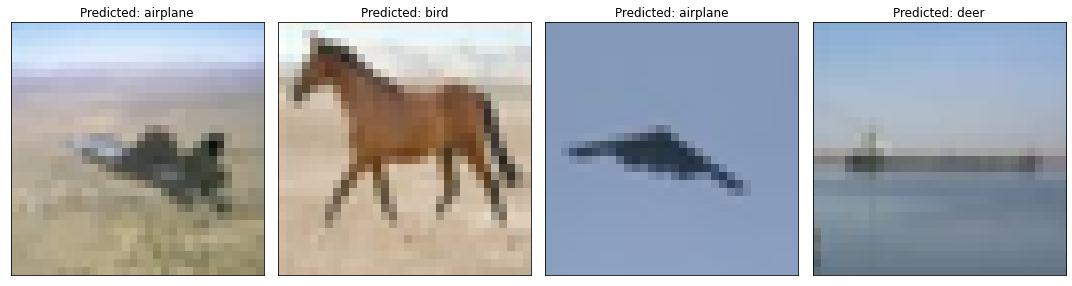

In [34]:
#@title Adversial attack

dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

model.to('cpu')
# set to eval, we don't want to modify it
model.eval()

# load images
imgs = []
for i in range(4):
  imgs.append(x[i])

imgs = torch.stack(imgs)

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {dataset.classes[y[p]]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [35]:
# prepare loss function for the method
loss = torch.nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.02

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

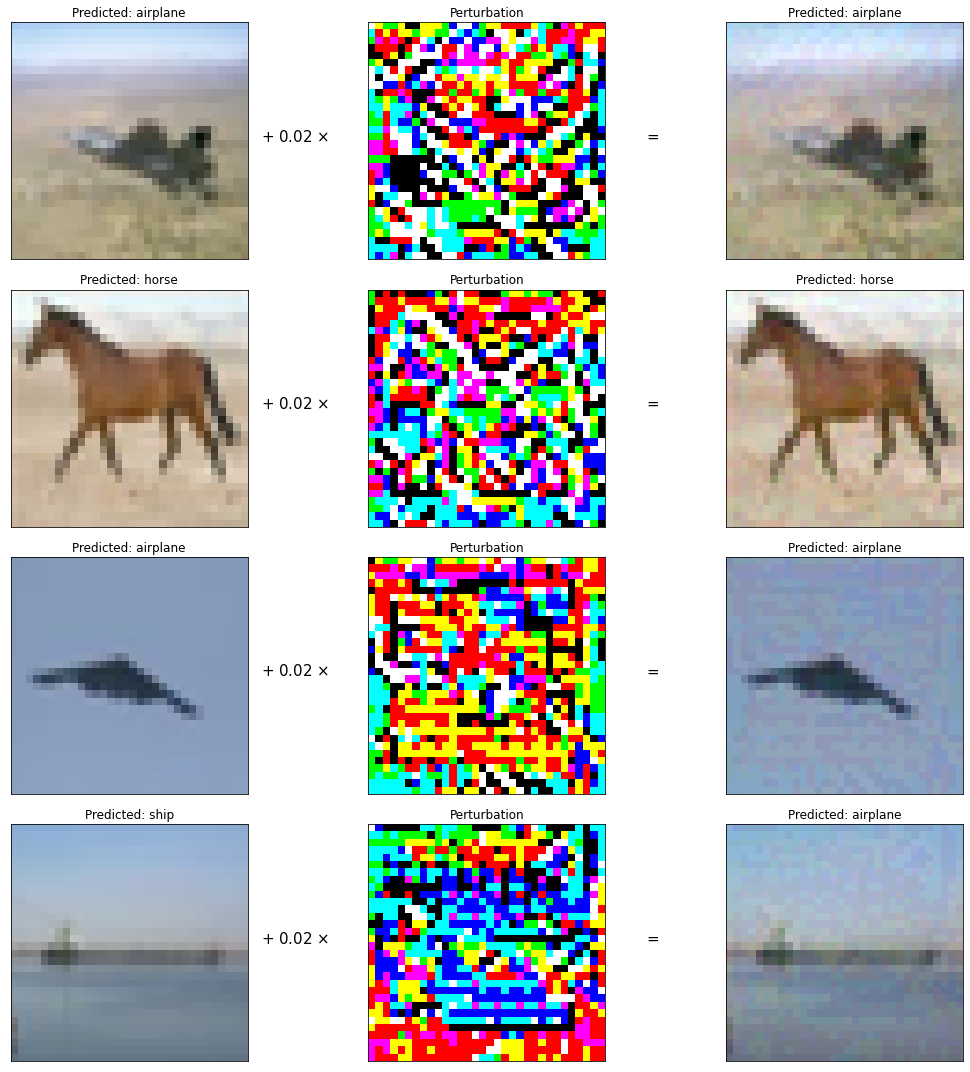

In [37]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)
labels = dataset.classes

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()